### Modelling primary and secondary shelf life simultaneously 

_this was done with 0 lit review on the subject, just out of interest_

First, some simple terms: 

 - **spoiling** is when the food product is no longer deemed consumable. 
 - **primary shelf life** is the duration between a food product leaving the production facility and it spoiling on the shelf. A common censoring event for this is a consumer purchases the product (i.e., we don't observe the event of the product spoiling **on the shelf**, but rather that event is censored and we only have a lower bound on the duration).
 - **secondary shelf life** is the duration between a food product being opened by a consumer and it spoiling. For fresh produce, this could also be considered when the produce leaves the store. 

Below is an excellent image from "Secondary Shelf Life: an Underestimated Issue".

![](https://i.imgur.com/klJiDHS.png)


There are many _wrong_ ways to model primary shelf life. A first approximation to model the primary shelf life is to treat purchase events as independent censoring. This has a few important flaws:

 1. discarding of information: when estimating the primary shelf life distribution, there is information included in its secondary shelf life. For an extreme example, suppose that almost every product is purchased by a consumer, and hence we see very few spoilages, and they happen very early. This makes estimating the survival curve farther out very difficult, as we have no information about lifetimes in that area. If we can observe the remaining lifetime, we can learn about the tail of the primary shelf life better.
 2. Assumption of independence between censoring distribution and duration distribution. Consumers are more likely to purchase "fresh-looking" produce, and tend to purchase products with a further out expiry date compared to a near expiry date. Thus, consumer-purchase censoring events are not independent of products' current shelf life. 
 
 
 Likewise, modelling the secondary shelf-life can be difficult: 
 
1. Like above, discarding of information occurs. The duration of the product in the store is highly correlated with the condition of the product, and hence is useful to untangle the secondary shelf life. Suppose that a product spoils after 7 days, but the store offers the product at a steep discount on day 6, increasing purchases. The secondary shelf life would have a dramatic drop at day 1 if we ignored primary shelf life. In fact, the primary shelf life should have this drop at day 7. 
 
Based on the above, you may think that adding duration-in-store as a covariate in a survival model would be sufficient, but the problem goes deeper: 
 
2. Frailty and immortal time bias: suppose we wish to compare the effects of a treatment/attribute on secondary shelf life for a product. Suppose that the treatment/attribute causes more "frailty", that is, its less stable foods spoil very quickly while in the store. Thus, upon a consumer's purchase, the only remaining products available are highly stable and will have a high secondary shelf life. Treatment does cause a higher secondary shelf life, but it's caused by a bias in the data. Controlling for the age in the store would not be adequate in this case. For example, the following conclusion is wrong due to this bias:

> Ontario tomatoes have a much lower secondary shelf than California tomatoes. 

The problem is that the worst California tomatoes spoil during transit, and these tomatoes will never be measured for their secondary shelf life. 
 
 
 
 -----
 
 Where am I going with all this? The idea is to model primary and secondary shelf life together, if the data is available. This model needs to account for 
 
 1. censoring due to administration stopping time, lack of follow up and consuming product: we can't watch a can of chickpeas exist for decades, so we must stop our study somewhere. Furthermore, if we rely on consumers to report back to us, some fraction will not and we have to consider that data censored. Finally, consumers want to eat the product, and hence we may never see the spoilage date. 
 
 2. variable purchase time: consumers can purchase a product at any time during its primary shelf life. Our model should be able to handle this. 
 
 
Let $\tau_i$ denote the time a consumer purchases / opens food product $i$. In survival analysis, it's often useful to model the hazard instead of the survival function. With that in mind, our shelf life hazard model looks like:

$$ 
h_i(t) = \begin{cases}
                        h_1(t)  & \text{if $t \le \tau_i$} \\
                        h_2(t-\tau_i) & \text{if $t > \tau_i $} \\
\end{cases}                
$$

This is the most general form. If we think that the same form of degradation that occurs in the store also happens in a consumer's storage, we can model this as:

$$ 
h_i(t) = \begin{cases}
                        h_1(t)  & \text{if $t \le \tau_i$} \\
                        h_1(t) + h_2(t-\tau_i) & \text{if $t > \tau_i $} \\
\end{cases}                
$$

For example, this model could represent risk of spoilage caused by existing microbe growth, $h_1(t)$, and $h_2(t)$ represents additional risk caused by consumer-caused contamination. 


Estimation of these models are complicated by the censoring and the case when a purchase/opened event is not observed. Nevertheless, it can be estimated with some careful coding. 

In [135]:
df = pd.read_csv("shelflife.csv")
df.head(5)

,T_obs,tau,E,obs_tau
0,13.390,1.176,True,True
1,0.875,0.505,False,True
2,13.003,14.003,False,False
3,13.047,0.720,True,True
4,0.075,1.075,False,False


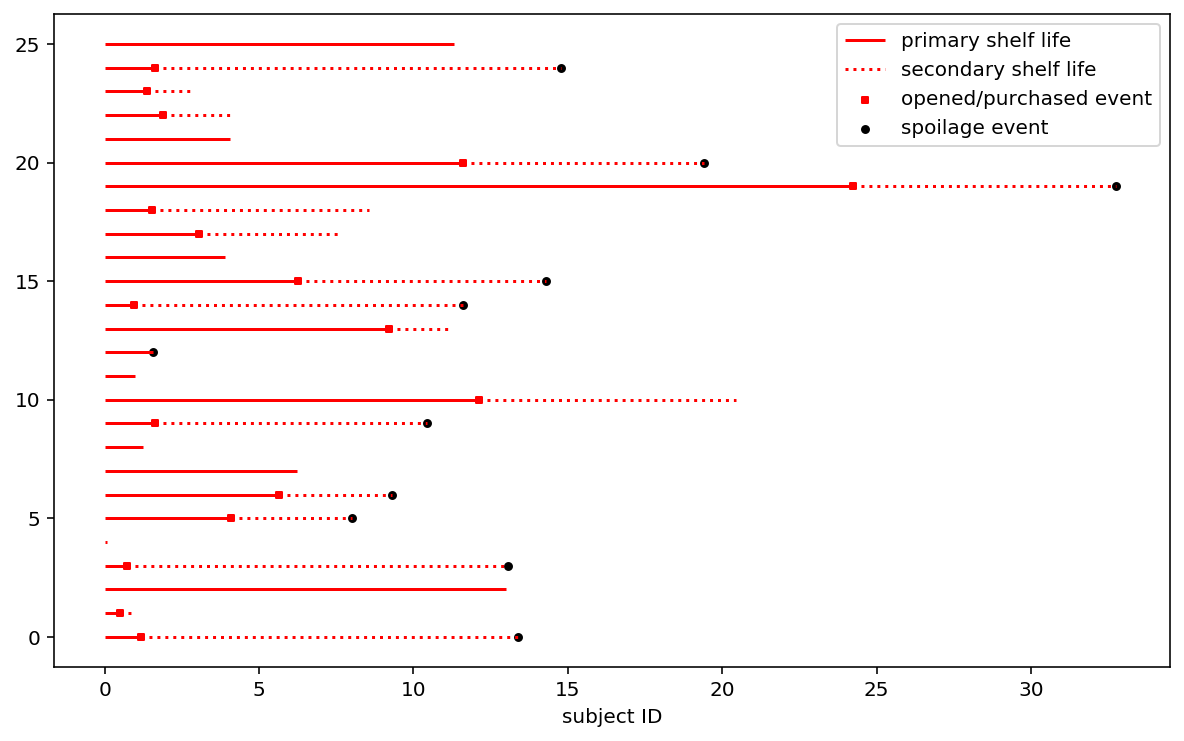

In [136]:
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(10,6))
ax = fig.subplots()

for i, row in df.loc[:25].iterrows():
    if row['obs_tau']:
        primary = ax.hlines(i, 0, row['tau'], color='r')
        secondary = ax.hlines(i, row['tau'], row['T_obs'], color='r', ls=":")
        purchase = ax.scatter(row['tau'], i, color="r", marker="s", s=12)
    else:
        primary = ax.hlines(i, 0, row['T_obs'], color='r')        
    m = "" if not row['E'] else "o"
    spoilage = ax.scatter(row['T_obs'], i, color="k", marker=m, s=12)
    
    if i == 0:
        primary.set_label('primary shelf life')
        secondary.set_label('secondary shelf life')
        purchase.set_label('opened/purchased event')
        spoilage.set_label('spoilage event')

plt.xlabel("time")
plt.xlabel("subject ID")
plt.legend()

 For computational reasons, it's better to express the model as a cumulative hazard:

$$
H_i(t) = \begin{cases}
                        H_1(t)  & \text{if $t \le \tau_i$} \\
                        H_2(t-\tau_i) & \text{if $t > \tau_i $} \\
\end{cases}                
$$

Let's give our model a parameteric form:

$$H_1(t) = \alpha t$$

$$H_2(t) = \left(\frac{t}{\lambda}\right)^{\rho}$$

That is, our primary shelf life is modelled by a constant hazard, and the secondary shelf life is modelled by a Weibull. Below is all the code that is needed to estimate the parameters. 

In [137]:
from autograd import grad, elementwise_grad, value_and_grad
from autograd import numpy as np
from scipy.optimize import minimize

def H1(params, t):
    log_alpha = params[0]
    alpha = np.exp(log_alpha)
    return t * alpha

def H2(params, t):
    log_lambda, log_rho = params
    lambda_, rho = np.exp(log_lambda), np.exp(log_rho)
    return (np.clip(t, 1e-4, np.inf) / lambda_) ** rho

def cumulative_hazard(params, t, tau): 
    #return np.where(t < tau, H1(params[:1], t), H1(params[:1], tau) + H2(params[1:], t-tau))

    # does the product keep degrading in the same manner when owned by the consumer?
    # recall that hazards are additive
    return np.where(t < tau, H1(params[:1], t), H1(params[:1], t) + H2(params[1:], t-tau))

hazard = elementwise_grad(cumulative_hazard, argnum=1)

def log_hazard(params, T, tau):
    return np.log(np.clip(hazard(params, T, tau), 1e-15, np.inf))


def survival_function(params, T, tau):
    return np.exp(-cumulative_hazard(params, T, tau))


def negative_log_likelihood(params, T, E, tau):
    n = T.shape[0]
    ll = 0
    ll += log_hazard(params, T, tau).sum()
    ll += -cumulative_hazard(params, T, tau).sum()
    return -ll/n


results = minimize(
    value_and_grad(negative_log_likelihood), 
    x0=np.array([0.0, 0.0, 0.0]), 
    args=(df['T_obs'].values, df['E'].values.astype(bool), df['tau'].values),
    jac=True)

print(results.x)

[-2.8866729   2.58703293  0.92460643]


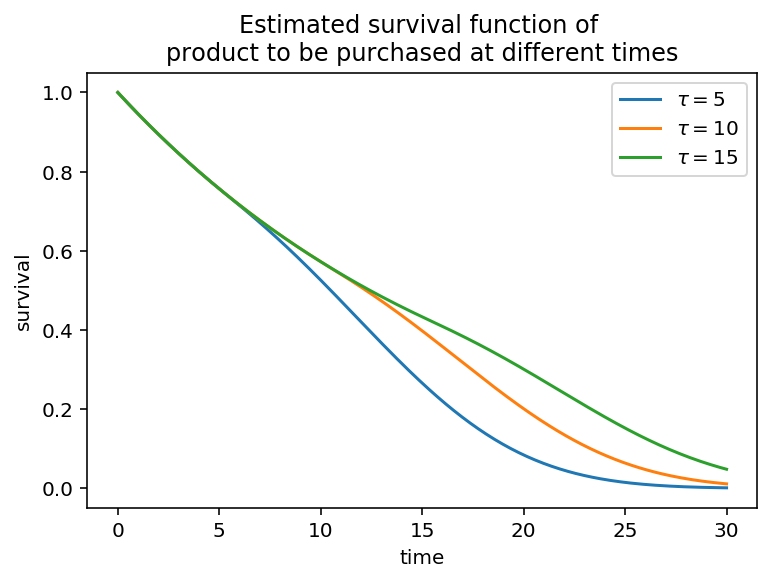

In [138]:
x = np.linspace(0, 30, 300)

for t in [5.0, 10., 15.0]:
    y = [survival_function(results.x, _, t) for _ in x]
    plt.plot(x, y, label=r"$\tau=%d$" % t)


plt.title("Estimated survival function of \nproduct to be purchased at different times");
plt.xlabel("time")
plt.ylabel("survival")
plt.legend()

Text(0, 0.5, 'survival')

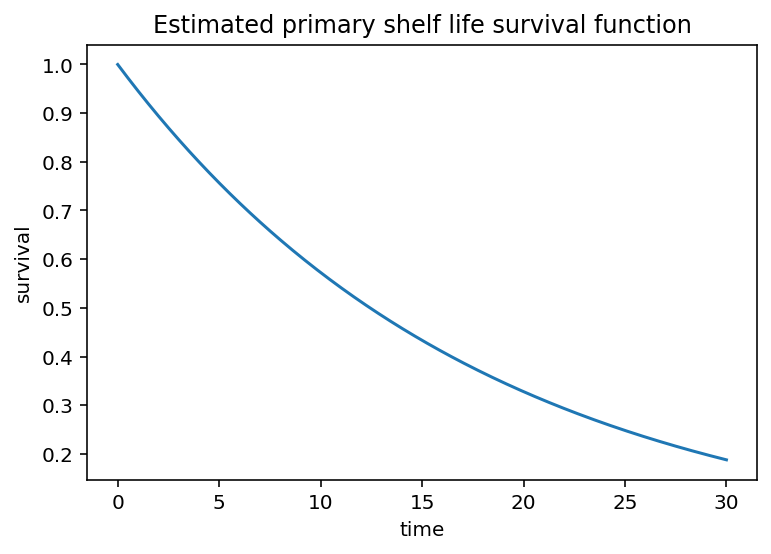

In [139]:
time = 5.0
x = np.linspace(0, 30, 300)
y = [np.exp(-H1(results.x[:1], _)) for _ in x]
plt.plot(x, y)
plt.title("Estimated primary shelf life survival function" );
plt.xlabel("time")
plt.ylabel("survival")

Text(0, 0.5, 'survival')

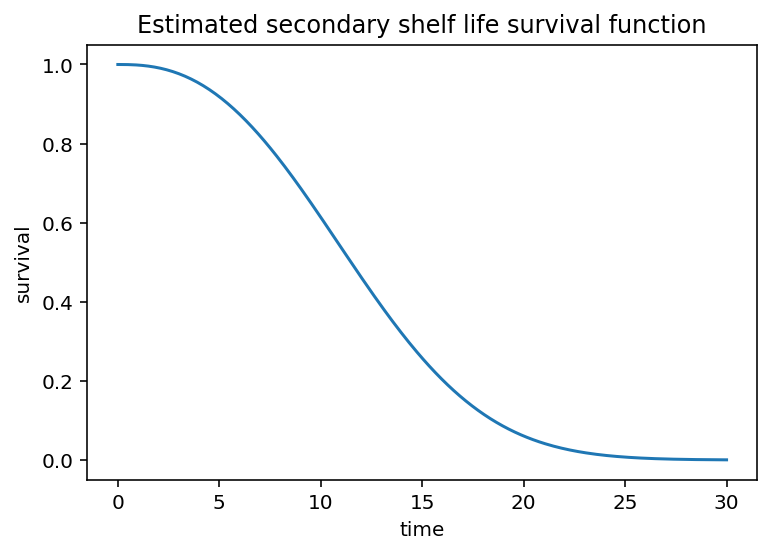

In [140]:
time = 5.0
x = np.linspace(0, 30, 300)
y = [np.exp(-H2(results.x[1:], _)) for _ in x]
plt.plot(x, y)
plt.title("Estimated secondary shelf life survival function" );
plt.xlabel("time")
plt.ylabel("survival")

In [141]:
from lifelines import WeibullFitter, ExponentialFitter
# only primary shelf life dataset - True iif E==true and obs_tau==False

ef = ExponentialFitter()

In [142]:
df.tail(25)

df_primary = df.copy()
df_primary['E'] = (df_primary['E'] & ~df['obs_tau'])

In [143]:
ef.fit(df_primary['T_obs'], df_primary['E']).print_summary()

In [144]:

df_secondary = df.copy()
df_secondary = df_secondary[df_secondary['obs_tau']]
df_secondary['T'] = df_secondary['T_obs'] - df_secondary['tau']

wf = WeibullFitter()
wf.fit(df_secondary['T'], df_secondary['E']).print_summary()